# General Presentation

## Introduction

This notebook is a demo of the use of ABIDES-Gym for training and testing a RL algorithm.

Details about ABIDES-Gym can be found on [arXiv](https://arxiv.org/pdf/2110.14771.pdf).

We assume the setup instructions in [ReadMe](https://github.com/jpmorganchase/abides-jpmc-public#readme) have been followed prior to running this notebook.

At the moment, ABIDES-Gym offers two trading environments:
- Daily Investor Environment: This environment presents an example of the classic problem wherean investor tries to make money buying and selling a stock through-out a single day. 
- Execution Environment: This environment presents an example of the optimal execution of a parent order problem. 

We will use the [ABIDES-Gym Execution environment](https://github.com/jpmorganchase/abides-jpmc-public/blob/main/abides-gym/abides_gym/envs/markets_execution_environment_v0.py) as an illustration of how to use ABIDES-Gym

## Problem setup 



This environment presents an example of the optimal execution of a parent order problem. The agent has either an initial inventory of the stocks it tries to trade out of or no initial inventory and tries to acquire a target number of shares. The goal is to realize this task while minimizing transaction cost from spreads and market impact. It does so by splitting the parent order into several smaller child orders.


We can define the problem parameters:
- $parentOrderSize$: Total size the agent has to execute (either buy or sell).
- $direction$: direction of the parentOrder (buy or sell).
- $timeWindow$: Time length the agent is given to proceed with parentOrderSize execution.
- $entryPrice$ is the midPrice_t at the beginning of the episode
- $nearTouch_t$ is the highest bidPrice if direction = buy else is the lowest askPrice
- $penalty$: it is a constant penalty per non-executed share at the end of the timeWindow.







## Action Space

The environment allows for three simple actions: "MARKET ORDER", "DO NOTHING" and "LIMIT ORDER". They are defined as follow:
- "MARKET ORDER": the agent places a market order of size $childOrderSize$ in the direction $direction$. (Instruction to buy or sell immediately at the current best available price)
- "LIMIT ORDER": the agent places a limit order of size $childOrderSize$ in the direction $direction$ at the price level $nearTouch_t$. (Buy or sell only at a specified price or better, does not guarantee execution)
- "DO NOTHING": no action is taken.

Before sending a "MARKET ORDER" or a "LIMIT ORDER", the agent will cancel any living order still in the Order Book.

## Reward

$$R_{total} = R_{slippage} + R_{Late Penalty} = R_{slippage} + \lambda \times Quantity_{NotExecuted}$$

with: 

- $ \lambda = penaltyFactor $

We define the step reward (slippage reward componant) as:

$$reward_t= \frac{PNL_t}{parentOrderSize}$$

with:

$$PNL_t = \sum_{o \in O_t } numside\cdot(entryPrice - fillPrice_{o})* quantity_{o}))$$
    
where $numside=1$ if direction is buy else $numside=0$ and $O_t$ is the set of orders executed between step $t-1$ and $t$
    
    
We also define an episode update reward that is computed at the end of the episode. Denoting $O^{episode}$ the set of all orders executed in the episode, it is defined as: 

- 0 if $\sum_{o \in O^{episode}} quantity_{o} = parentOrderSize$
        
- else $|penalty \times ( parentOrderSize - \sum_{o \in O^{episode}} quantity_{o})|$
        

## State Space

The experimental agent perceives the market through the state representation:
        
$$s(t)=( holdingsPct_t, timePct_t, differencePct_t, imbalance5_t, imbalanceAll_t, priceImpact_t, spread_t, directionFeature_t, R^{k}_t)$$
       
where:
- $holdingsPct_t = \frac{holdings_t}{parentOrderSize}$: the execution advancement
- $timePct_t=\frac{t - startingTime}{timeWindow}$: the time advancement
- $differencePct_t = holdingsPct_t - timePct_t$ 
- $priceImpact_t = midPrice_t - entryPrice$
- $imbalance_t=\frac{bids \ volume}{ bids \ volume + asks \ volume}$ using the first 3 levels of the order book. Value is respectively set to $0, 1, 0.5$ for no bids, no asks and empty book.
- $spread_t=bestAsk_t-bestBid_t$
- $directionFeature_t= midPrice_t-lastTransactionPrice_t$
- $R^k_t=(r_t,...,r_{t-k+1})$ series of mid price differences, where $r_{t-i}=mid_{t-i}-mid_{t-i-1}$. It is set to 0 when undefined. By default $k=3$ 
    

# Imports

In [38]:
# Only a few import are needed

import gym
import abides_gym

# Exploration of ABIDES-Gym with Gym runner

## Import the specific environment and set the global seed 

In [39]:
#import abides gym 
env = gym.make(
        #"markets-execution-v0",
        "markets-daily_investor-v0",
        background_config="rmsc04"
    )
#set the general seed
env.seed(0)

[0]

## Start the simulation

A simulation is composed of different steps before enabling the Gym agent to act in the environment:
- start the day (00:00:00): No agent can act on the market 
- open the market (09:30:00): Background agents can act on the market
- authorize the Gym agent to act (09:30:00 + N minutes) with N=5 minutes here

The sequence of actions is called by the classic Gym function:
```python
.reset()
```

It returns the state of the market at time 09:30:00 + N minutes.

In [40]:
state = env.reset()

In [41]:
#The state features are as follow
#holdings_pct, time_pct, diff_pct, imbalance_all, imbalance_5, price_impact, spread, directiom, returns

print(state)

[[ 0.       ]
 [ 0.5130776]
 [ 1.       ]
 [-0.5      ]
 [ 0.       ]
 [ 0.       ]
 [ 0.       ]]


## Agent Action

In [42]:
env.action_space

Discrete(3)

Three actions are available for the agent:
- 0: MKT buy order of size order_fixed_size
- 1: Hold
- 2: MKT sell order of size order_fixed_size

## Step in the Simulation

The step is called by the classic Gym function:
```python
.step(action)
```

It returns the classic:
- the state of the market after taking the action and waiting until the next time step
- the reward obtained during the step 
- whether the environment episode is finished 
- info dictionnary: in default mode, return interesting metrics to track during the training of the agent. May be used in debug_mode for more information passed through

In [43]:
# agent does action 0 
state, reward, done, info = env.step(0)

In [44]:
print('State:')
print(state)
print('-------------------------------------')
print('Reward:')
print(reward)
print('-------------------------------------')
print('Done:')
print(done)
print('-------------------------------------')
print('Info:')
print(info)

State:
[[10.       ]
 [ 0.6331277]
 [ 1.       ]
 [ 0.5      ]
 [ 0.       ]
 [ 0.       ]
 [ 0.       ]]
-------------------------------------
Reward:
-0.002564102564102564
-------------------------------------
Done:
False
-------------------------------------
Info:
{'remaining_holding': 10, 'remaining_cash': -60, 'action_counter': {'action_0': 1, 'action_1': 0, 'action_2': 0}, 'padded_return': 0.0, 'holdings': 10, 'imbalance': 0.6331276696725202, 'spread': 1, 'direction_feature': 0.5, 'marked_to_market': [1000000, 999990], 'dense_reward': -0.002564102564102564, 'sparse_reward': 0, 'raw_state': {'parsed_mkt_data': {'bids': [[(100005, 353), (100004, 675), (99997, 149), (99996, 38), (99986, 38), (99976, 38), (99975, 100), (99966, 38), (99957, 100), (99956, 138)], [(100005, 1199), (100004, 100), (99999, 35), (99997, 149), (99993, 35), (99987, 35), (99981, 35), (99975, 35), (99969, 35), (99963, 35)]], 'asks': [[(100006, 453), (100007, 564), (100008, 100), (100009, 100), (100013, 100), (10

# Training an RL algorithm in ABIDES: Example with RLlib

Remark: The notebook demonstrates the use of [RLlib](https://docs.ray.io/en/latest/rllib-algorithms.html) to train the execution agent, however any open-source library or own code will be compatible with ABIDES-Gym. 

## Imports

In [45]:
import ray
from ray import tune

# Import to register environments
import abides_gym


from ray.tune.registry import register_env
# import env 

from abides_gym.envs.markets_daily_investor_environment_v0 import (
    SubGymMarketsDailyInvestorEnv_v0,
)

## Runner

RLlib enables easy parallelization with for example here the training of a DQN agent in RMSC04 doing a grid_search on the value of the learning rate. 

We also run for 3 different global seeds to verify the robustness of our learning.


**Note**: 
- Would recommend to copy this cell in a python script and let it run in the back with [screen](https://linuxize.com/post/how-to-use-linux-screen/) or [tmux](https://www.hamvocke.com/blog/a-quick-and-easy-guide-to-tmux/) for instance. 
- If you want to execute the cell, turn the execute_cell_flag to True

In [46]:
execute_cell_flag = True

if execute_cell_flag:

    ray.shutdown()
    ray.init()

    """
    DQN's default:
    train_batch_size=32, sample_batch_size=4, timesteps_per_iteration=1000 -> workers collect chunks of 4 ts and add these to the replay buffer (of size buffer_size ts), then at each train call, at least 1000 ts are pulled altogether from the buffer (in batches of 32) to update the network.
    """
    register_env(
        "markets-daily_investor-v0",
        lambda config: SubGymMarketsDailyInvestorEnv_v0(**config),
    )


    name_xp = "a3c_execution_daily_1" #change to your convenience

    tune.run(
        "A3C",
        name=name_xp,
        resume=True,
        stop={"training_iteration": 100},  
        checkpoint_at_end=True,
        checkpoint_freq=5,
        config={
            "env": "markets-daily_investor-v0",
            "env_config": {"background_config":"rmsc04",
                           "timestep_duration":"10S",
                           "order_fixed_size": 50,
             },
            "seed": tune.grid_search([1, 2]),
            "num_gpus": 0,
            "num_workers": 0,
            "hiddens": [50, 20],
            "gamma": 1,
            "lr": tune.grid_search([0.001,0.0001, 0.01]),
            "framework": "torch",
            "observation_filter": "MeanStdFilter",
        },
    )

The users can track its experimentation on:
- ray dashboard: port 8265
- TensorBoard: port 6006 

Tensorboard can be launched with the following command in terminal:

```bash
tensorboard --logdir=~/ray_results/{name_xp}
```


# Test of the algorithm - Rollouts

This part illustrates the implementation of 4 hand-crafted policies and 1 Reinforcement Learning agent learned with RRlib.

## Define or load a policy

In [47]:
import numpy as np 
np.random.seed(0)
import ray.rllib.agents.dqn as dqn
from ray.tune import Analysis


#each policy needs to have:
# - an attribute name 
# - a method get_action


class policyPassive:
    def __init__(self):
        self.name = 'passive'
        
    def get_action(self, state):
        return 2
        
class policyAggressive:
    def __init__(self):
        self.name = 'aggressive'
        
    def get_action(self, state):
        return 0
    
class policyRandom:
    def __init__(self):
        self.name = 'random'
        
    def get_action(self, state):
        return np.random.choice([0,1,2])
    
class policyRandomWithNoAction:
    def __init__(self):
        self.name = 'random_no_action'
        
    def get_action(self, state):
        return np.random.choice([0,2])
    
class policyRL:
    """
    policy learned during the training
    get the best policy from training {name_xp}
    Use this policy to compute action
    """
    def __init__(self):
        self.name = 'rl'
        
        ##### LOADING POLICY 
        # cell specific to ray to 
        #this part is to get a path
        # https://github.com/ray-project/ray/issues/4569#issuecomment-480453957
        name_xp = "dqn_execution_daily_test_1" 
        
        data_folder = f"~/ray_results/{name_xp}"
        analysis = Analysis(data_folder)
        trial_dataframes = analysis.trial_dataframes
        trials = list(trial_dataframes.keys())
        best_trial_path = analysis.get_best_logdir(metric='episode_reward_mean', mode='max')
        #can replace by string here - any checkpoint of your choice 
        best_checkpoint = analysis.get_best_checkpoint(trial = best_trial_path, mode='max')
        
        # define the meta parameters of the policy in order to set the trained
        config = dqn.DEFAULT_CONFIG.copy()
        config["framework"]= "torch"
        config["observation_filter"]= "MeanStdFilter"
        config["hiddens"]= [50, 20]
        config["env_config"]= {
                        "background_config":"rmsc04",
                        "timestep_duration":"10S",
                        "order_fixed_size": 50,
             }

        self.trainer = dqn.DQNTrainer(config=config, env = "markets-daily_investor-v0")
        #load policy from checkpoint
        self.trainer.restore(best_checkpoint)
        
        
    def get_action(self, state):
        return self.trainer.compute_action(state)    
        

In [48]:
name_xp = "dqn_execution_daily_test_1" 
        
data_folder = f"~/ray_results/{name_xp}"
analysis = Analysis(data_folder)
trial_dataframes = analysis.trial_dataframes
trials = list(trial_dataframes.keys())
best_trial_path = analysis.get_best_logdir(metric='episode_reward_mean', mode='max')
#can replace by string here - any checkpoint of your choice 
best_checkpoint = analysis.get_best_checkpoint(trial = best_trial_path, mode='max')

No checkpoints have been found for trial /global/home/users/lijieliu/ray_results/dqn_execution_daily_test_1/DQN_markets-daily_investor-v0_e319b_00057_57_order_fixed_size=100,timestep_duration=30S,lr=0.0001,seed=3_2023-02-25_17-36-37.


In [49]:
# define the meta parameters of the policy in order to set the trained
config = dqn.DEFAULT_CONFIG.copy()
config["framework"]= "torch"
config["observation_filter"]= "MeanStdFilter"
config["hiddens"]= [50, 20]
config["env_config"]= { "background_config":"rmsc04",
                        "timestep_duration":"10S",
                        "order_fixed_size": 50,}

In [50]:
mytrainer = dqn.DQNTrainer(config=config, env = "markets-daily_investor-v0")

2023-02-26 15:36:00,775	WARNING deprecation.py:38 -- DeprecationWarning: `ReplayBuffer(size)` has been deprecated. Use `ReplayBuffer(capacity)` instead. This will raise an error in the future!
Install gputil for GPU system monitoring.


## Testing (rollout) infrastructure

**Note**: This part may be included in ABIDES-GYM source code in the future.

In [51]:
def generate_env(seed):
    """
    generates specific environment with the parameters defined and set the seed
    """
    env = gym.make(
            "markets-daily_investor-v0",
            background_config="rmsc04",
            timestep_duration="10S",
            order_fixed_size= 50,
        )

    env.seed(seed)
    
    return env

In [52]:
from collections.abc import MutableMapping
import pandas as pd

def flatten_dict(d: MutableMapping, sep: str= '.') -> MutableMapping:
    [flat_dict] = pd.json_normalize(d, sep=sep).to_dict(orient='records')
    return flat_dict

def run_episode(seed = None, policy=None):
    """
    run fully one episode for a given seed and a given policy
    """
    
    env = generate_env(seed)
    state = env.reset()
    done = False
    episode_reward = 0 
    
    while not done:
        action = policy.get_action(state)
        state, reward, done, info = env.step(action)
        episode_reward += reward
    
    #could add a few more... 
    output = flatten_dict(info) 
    output['episode_reward'] = episode_reward
    output['name'] = policy.name
    return output
        
        
    

In [53]:
seed = 0
policy = policyRandom()
env = generate_env(seed)
state = env.reset()
done = False
episode_reward = 0 

In [54]:
action = policy.get_action(state)
state, reward, done, info = env.step(action)
episode_reward += reward

In [55]:
info

{'remaining_holding': 0,
 'remaining_cash': 1000000,
 'action_counter': {'action_0': 0, 'action_1': 1, 'action_2': 0},
 'padded_return': 0.0,
 'holdings': 0,
 'imbalance': 0.513077593722755,
 'spread': 1,
 'direction_feature': -0.5,
 'marked_to_market': [1000000, 1000000],
 'dense_reward': 0.0,
 'sparse_reward': 0,
 'raw_state': {'parsed_mkt_data': {'bids': [[(100005, 353),
     (100004, 675),
     (99997, 149),
     (99996, 38),
     (99986, 38),
     (99976, 38),
     (99975, 100),
     (99966, 38),
     (99957, 100),
     (99956, 138)],
    [(100005, 353),
     (100004, 675),
     (99997, 149),
     (99996, 38),
     (99986, 38),
     (99976, 38),
     (99975, 100),
     (99966, 38),
     (99957, 100),
     (99956, 138)]],
   'asks': [[(100006, 453),
     (100007, 564),
     (100008, 100),
     (100009, 100),
     (100013, 100),
     (100014, 100),
     (100017, 38),
     (100019, 100),
     (100027, 38),
     (100037, 38)],
    [(100006, 453),
     (100007, 564),
     (100008, 100)

The info here is NULL. Therefore the code below does not work.

We need to revise the ABIDES's code here because ABIDES only has records of the execution environment.

In order to do that, we need to check the execution environment python file and try to revise the daily investor envs file. Briefly speaking, 
- Initialize metrics at first
- Add some codes in the part of raw-state-to-done to record important info and metrics to compare 


In [33]:
policies = [policyAggressive(), policyRandom(), policyPassive(), policyRandomWithNoAction()]
seed = 0
run_episode(seed=seed, policy=policies[0])

KeyboardInterrupt: 

Process ForkPoolWorker-27:
Process ForkPoolWorker-26:
Traceback (most recent call last):
  File "/global/home/users/lijieliu/.local/lib/python3.9/site-packages/multiprocess/process.py", line 315, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/global/home/users/lijieliu/.local/lib/python3.9/site-packages/multiprocess/process.py", line 315, in _bootstrap
    self.run()
  File "/global/home/users/lijieliu/.local/lib/python3.9/site-packages/multiprocess/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/global/home/users/lijieliu/.local/lib/python3.9/site-packages/multiprocess/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/global/home/users/lijieliu/.local/lib/python3.9/site-packages/multiprocess/pool.py", line 114, in worker
    task = get()
  File "/global/home/users/lijieliu/.local/lib/python3.9/site-packages/multiprocess/pool.py", line 114, in worker
    task = get()
  File "/global/home/u

In [57]:
from p_tqdm import p_map
import pandas as pd 
from multiprocessing import Pool
from pathos.multiprocessing import ProcessingPool as Pool
#from ray.util.multiprocessing import Pool



def run_N_episode(N):
    """
    run in parallel N episode of testing for the different policies defined in policies list
    heads-up: does not work yet for rllib policies - pickle error
    #https://stackoverflow.com/questions/28821910/how-to-get-around-the-pickling-error-of-python-multiprocessing-without-being-in

    need to run the rllib policies with following cell (not in parralel)
    
    """
    #define policies 
    policies = [policyAggressive()]
    seeds = [i for i in range(N)]
    
    tests = [{"policy":policy, 'seed':seed} for policy in policies for seed in seeds]
    
    def wrap_run_episode(param):
        return run_episode(**param)
    
    outputs = p_map(wrap_run_episode, tests)
    #outputs = Pool().map(wrap_run_episode, tests)
    
    return outputs

N = 1
#outputs = run_N_episode(N) 
outputs=[]

In [58]:
#cannot do in parrallel here for now - pickling errors
from tqdm import tqdm
for i in tqdm(range(N)):
    outputs.append(run_episode(seed = i, policy=policyRL()))

  0%|          | 0/1 [00:00<?, ?it/s]No checkpoints have been found for trial /global/home/users/lijieliu/ray_results/dqn_execution_daily_test_1/DQN_markets-daily_investor-v0_e319b_00057_57_order_fixed_size=100,timestep_duration=30S,lr=0.0001,seed=3_2023-02-25_17-36-37.
2023-02-26 15:37:34,891	WARNING deprecation.py:38 -- DeprecationWarning: `ReplayBuffer(size)` has been deprecated. Use `ReplayBuffer(capacity)` instead. This will raise an error in the future!
Install gputil for GPU system monitoring.
  0%|          | 0/1 [00:01<?, ?it/s]


TypeError: unsupported operand type(s) for +: 'NoneType' and 'str'

In [68]:
import matplotlib.pyplot as plt

In [96]:
i+=1
plt.plot(pd.DataFrame(outputs).marked_to_market[i], label=pd.DataFrame(outputs).name[i])
plt.legend()

KeyError: 22

In [65]:
pd.DataFrame(outputs).groupby(by='name').mean()

,remaining_holding,remaining_cash,padded_return,holdings,imbalance,spread,direction_feature,dense_reward,sparse_reward,action_counter.action_0,action_counter.action_1,action_counter.action_2,episode_reward
name,,,,,,,,,,,,,
aggressive,19437.5,-1.943483e+09,-8.125,19437.5,0.524507,2.25,0.875,-1.625577,0.0,388.75,0.00,0.00,-6.617750
passive,-16650.0,1.665267e+09,16.000,-16650.0,0.364232,2.50,0.500,-2.139530,0.0,0.00,0.00,333.00,-6.922596
random,100.0,-9.198974e+06,0.000,100.0,0.359708,2.75,-1.125,0.000000,0.0,775.50,761.25,774.25,0.278316
random_no_action,-50.0,5.919796e+06,0.000,-50.0,0.658487,1.25,-0.125,0.000000,0.0,1154.75,0.00,1156.25,-0.575462
rl,-17500.0,1.750302e+09,15.125,-17500.0,0.374664,2.25,0.875,-1.937737,0.0,2.50,3.25,352.50,-6.181494


In [65]:
df = pd.DataFrame(outputs)

In [66]:
df.groupby(by='name').mean()

,remaining_holding,remaining_cash,padded_return,holdings,imbalance,spread,direction_feature,marked_to_market,dense_reward,sparse_reward,action_counter.action_0,action_counter.action_1,action_counter.action_2,episode_reward
name,,,,,,,,,,,,,,
aggressive,27891.175,-2.790383e+09,-12.6750,27891.175,0.522160,4.575,0.9125,1000391.975,-2.558916,0.0,558.650,0.000,0.000,0.003350
passive,-21488.750,2.148642e+09,16.2875,-21488.750,0.453934,3.850,0.0750,203454.450,-2.216879,0.0,0.000,0.000,429.850,-6.808082
random,513.700,-5.043147e+07,-0.2750,513.700,0.501332,2.200,-0.4750,906753.100,-0.009126,0.0,774.000,769.650,763.800,-0.796982
random_no_action,-101.025,1.096700e+07,-4.3500,-101.025,0.518211,1.625,-0.0625,812363.925,-0.175965,0.0,1130.825,0.000,1133.950,-1.603727
rl,-20990.000,2.098838e+09,15.1375,-20990.000,0.485551,3.650,-0.7000,165208.000,-2.504786,0.0,2.575,2.975,422.425,-7.134974


## Plotting results

In [ ]:
#convert results in a dataframe with all metrics
df = pd.DataFrame(outputs)
df['ep_len'] = df['action_counter.action_0'] + df['action_counter.action_1'] + df['action_counter.action_2']
df.head()

In [ ]:
#group by policy name and sort
df_g = df.groupby(by='name').mean()

list_interest =  ['episode_reward', 'time_pct', 
               'holdings_pct', 'late_penalty_reward', 
               'imbalance_5', 'spread', 'action_counter.action_0', 'action_counter.action_1',
              'action_counter.action_2']

df_g.sort_values(by = 'episode_reward', ascending=False)[list_interest]

Example of rollout comparison (output of the cell):
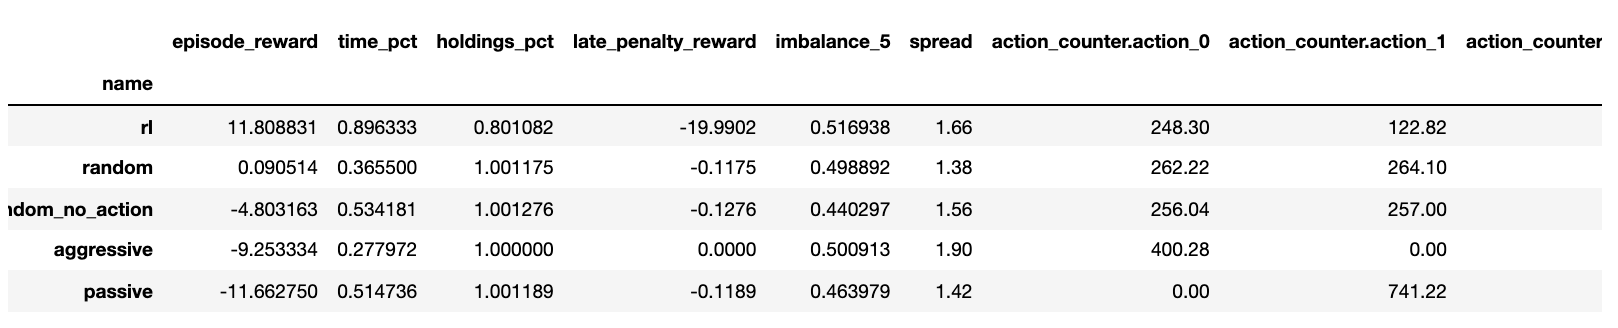

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [ ]:
#distribution plots
for metric in list_interest:
    print(f'======================={metric}========================')
    sns.displot(data = df, x=metric, hue='name', bins=10)
    plt.show()
    sns.displot(data = df, x=metric, hue='name',  kind="kde")
    plt.show()

Example of rollout distribution plots (output of the cell):
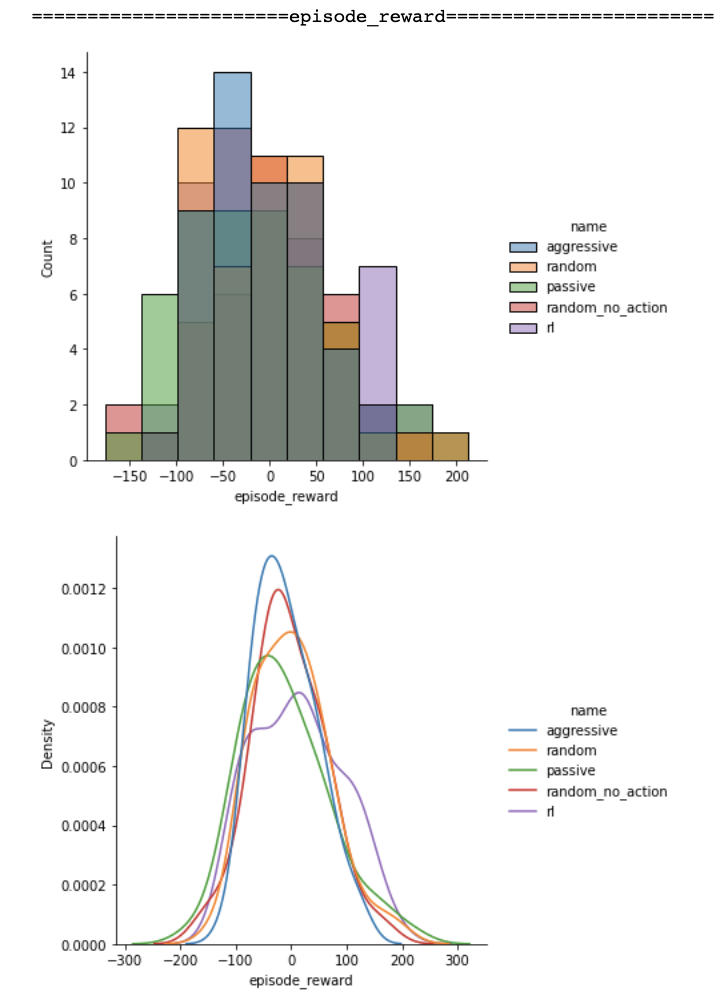

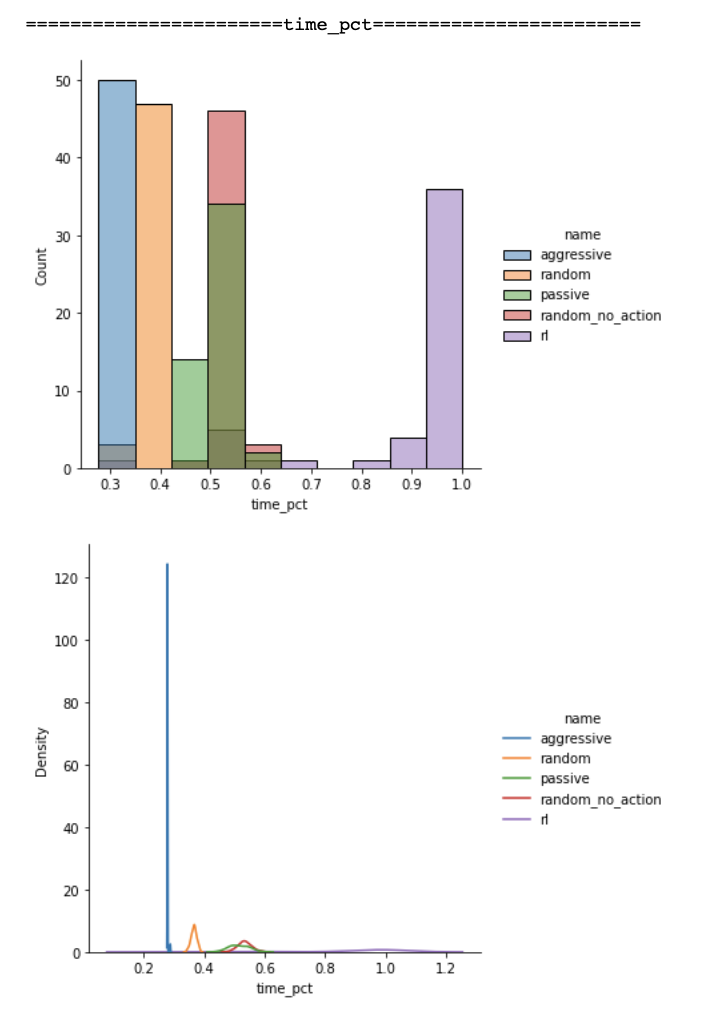

# Future ABIDES-Gym-Markets environment

Plan for ABIDE-Gym environments to offer raw l2 data instead of computed features as state space. 
These new environement will be called markets-XXX-v1.